In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap
from image import *
from psfmodel import *
from utils import *

In [2]:
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
from jax import random
from jax.config import config
config.update('jax_enable_x64', True)

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import corner

In [4]:
plt.rcParams['figure.dpi'] = 100

In [5]:
image_obs = PixelImage(30, 30)
image_super = PixelImage(30, 30, dx=1./3., dy=1./3.)

In [6]:
print (image_obs.shape, image_super.shape)

(30, 30) (90, 90)


In [7]:
%%time 
S = supersampling_matrix(image_super, image_obs)

CPU times: user 471 ms, sys: 457 ms, total: 928 ms
Wall time: 818 ms


In [94]:
Nsource = 10*2
np.random.seed(124)
norms = np.ones(Nsource)
#norms = 10**np.random.rand(Nsource)
xcenters = np.random.rand(Nsource) * image_super.xmax
ycenters = np.random.rand(Nsource) * image_super.ymax
sigma = 1.

In [95]:
image_super.Z = simulate_gaussian_sources(image_super, norms, xcenters, ycenters, sigma)
Zobs = super_to_obs(image_super.Z, image_obs)

In [96]:
np.random.seed(123)
sigmaerr = 2e-3
Zerr = np.random.randn(*image_obs.shape)*sigmaerr
image_obs.Z = Zobs + Zerr

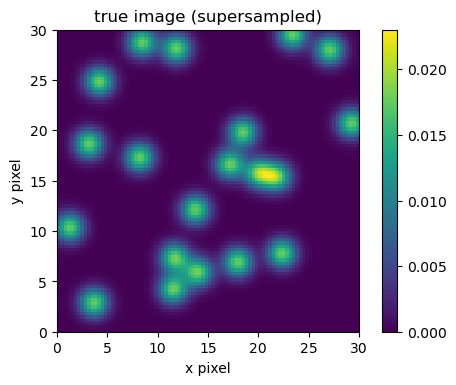

In [97]:
plot_image(image_super, title='true image (supersampled)')

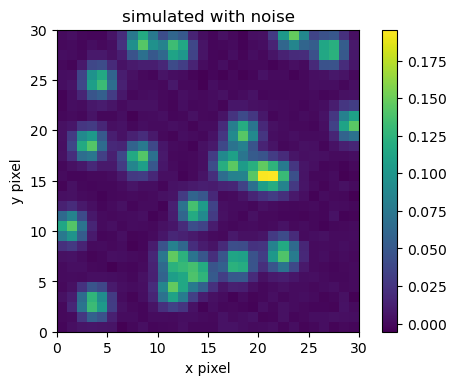

In [98]:
plot_image(image_obs, title='simulated with noise')

In [99]:
xext, yext = 7., 7.
dx, dy = 1./3., 1./3.
gridpsf = GridPSFModel(xext, yext, dx, dy)

PSF grid shape: (21, 21)
x centers: [-3.33333333 -3.         -2.66666667 -2.33333333 -2.         -1.66666667
 -1.33333333 -1.         -0.66666667 -0.33333333  0.          0.33333333
  0.66666667  1.          1.33333333  1.66666667  2.          2.33333333
  2.66666667  3.          3.33333333]
y centers: [-3.33333333 -3.         -2.66666667 -2.33333333 -2.         -1.66666667
 -1.33333333 -1.         -0.66666667 -0.33333333  0.          0.33333333
  0.66666667  1.          1.33333333  1.66666667  2.          2.33333333
  2.66666667  3.          3.33333333]


In [100]:
#image_obs.Z = (U@np.ones(gridpsf.size)).reshape(*image_obs.shape)
#plot_image(image_obs)

In [257]:
xcenters_guess = np.array(xcenters)
ycenters_guess = np.array(ycenters)
norms_guess = []
for x,y in zip(xcenters_guess, ycenters_guess):
    norms_guess.append(np.sum(image_obs.Z[image_obs.aperture_flux(x, y, 3.)]))
lnfluxes_guess = np.log(np.array(norms_guess))

In [260]:
#def optimize_flux_and_position(lnfluxes_guess, xcenters_guess, ycenters_guess, idx_anchor):
idx_anchor = 0

In [261]:
p_anchor = {"lnfluxes": lnfluxes_guess[idx_anchor], "xcenters": xcenters_guess[idx_anchor], "ycenters": ycenters_guess[idx_anchor]}

In [262]:
Zanchor_mean = np.mean(image_obs.Z[image_obs.circular_aperture(p_anchor['xcenters'], p_anchor['ycenters'], 3.)])
p_init = {
    "lnnorms": lnfluxes_guess,
    "xcenters": xcenters_guess,
    "ycenters": ycenters_guess,
    "lnlenx": np.float64(0.), # required so that pytree leaves have shapes
    "lnleny": np.float64(0.),
    "lnamp": np.float64(np.log(Zanchor_mean))
}

#p_low = {"lnnorms": p_init['lnnorms']-5, "xcenters": p_init['xcenters']-2., "ycenters": p_init['ycenters']-2., "lnlenx": p_init['lnlenx']-2, "lnleny": p_init['lnleny']-2, "lnamp": p_init['lnamp']-3}
#p_high = {"lnnorms": p_init['lnnorms']+5, "xcenters": p_init['xcenters']+2., "ycenters": p_init['ycenters']+2., "lnlenx": p_init['lnlenx']+2, "lnleny": p_init['lnleny']+2, "lnamp": p_init['lnamp']+3}

In [265]:
p_low, p_high = {}, {}
for key,val in p_init.items():
    p_low[key] = val - 2.
    p_high[key] = val + 2.

In [242]:
def gpkernel(X1d, Y1d, lenx, leny, amp2):
    dx = X1d[:,None] - X1d[None,:]
    dy = Y1d[:,None] - Y1d[None,:]
    dx2 = jnp.power(dx / lenx, 2.0)
    dy2 = jnp.power(dy / leny, 2.0)
    cov = amp2 * jnp.exp(-0.5*dx2-0.5*dy2)
    return cov

In [243]:
def gp_marginal(gridpsf, p, p_anchor, idx_anchor, image_obs, sigma_err, image_super, S, return_pred=False):
    norms = jnp.r_[p['norms'][:idx_anchor], p_anchor['norms'], p['norms'][idx_anchor+1:]]
    xcenters = jnp.r_[p['xcenters'][:idx_anchor], p_anchor['xcenters'], p['xcenters'][idx_anchor+1:]]
    ycenters = jnp.r_[p['ycenters'][:idx_anchor], p_anchor['ycenters'], p['ycenters'][idx_anchor+1:]]
    lenx, leny, amp2 = jnp.exp(p['lnlenx']), jnp.exp(p['lnleny']), jnp.exp(2*p['lnamp'])
    cov_f = gpkernel(gridpsf.X1d, gridpsf.Y1d, lenx, leny, amp2)
    T = gridpsf.translation_matrix(image_super.X, image_super.Y, norms, xcenters, ycenters)
    U = jnp.dot(S, T)
    cov_d = sigma_err**2 * jnp.eye(image_obs.size)
    
    if return_pred:
        """ prediction for PSF vector """
        Sigma_pred = cov_f - cov_f@U.T@jnp.linalg.inv(cov_d+U@cov_f@U.T)@U@cov_f
        prec_d = 1. / sigma_err**2 * jnp.eye(image_obs.size)
        mu_pred = Sigma_pred@U.T@prec_d@image_obs.Z1d
        return mu_pred, Sigma_pred
    
    cov = jnp.dot(U, jnp.dot(cov_f, U.T)) + cov_d
    mv = dist.MultivariateNormal(loc=0., covariance_matrix=cov)
    return mv.log_prob(image_obs.Z1d)

#from functools import partial
#@partial(jit, static_argnums=(1,))
def neg_log_like(p):#, gridpsf, idx_anchor, image_obs, image_super, S):
    return -gp_marginal(gridpsf, p, p_anchor, idx_anchor, image_obs, sigmaerr, image_super, S)

In [244]:
import jaxopt
method = "TNC"
solver = jaxopt.ScipyBoundedMinimize(fun=neg_log_like, method=method)

In [245]:
mu, sigma = gp_marginal(gridpsf, p_init, p_anchor, idx_anchor, image_obs, sigmaerr, image_super, S, return_pred=True)

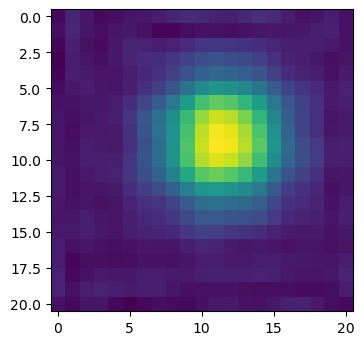

In [246]:
plt.imshow(mu.reshape(*gridpsf.shape))

In [247]:
%%time
res = solver.run(p_init, bounds=(p_low, p_high))#, gridpsf=gridpsf, idx_anchor=idx_anchor, image_obs=image_obs, image_super=image_super, S=S)

KeyboardInterrupt: 

In [216]:
popt, state = res

In [230]:
popt

{'lnamp': DeviceArray(-5.71944151, dtype=float64),
 'lnlenx': DeviceArray(0.25399101, dtype=float64),
 'lnleny': DeviceArray(0.31663819, dtype=float64),
 'norms': DeviceArray([1.        , 0.99752739, 0.99721236, 0.98577231, 0.9788343 ,
              1.00443669, 1.03287821, 0.97770934, 0.99014701, 1.00351208,
              0.98597126, 0.99990316, 0.99459717, 1.00495694, 0.99884913,
              0.98326064, 0.99290927, 0.9764601 , 0.99192775, 1.00639069],            dtype=float64),
 'xcenters': DeviceArray([ 3.68194718, 22.35792353, 17.15030698, 13.72585629,
              11.53329855,  8.2055119 , 20.04837614, 11.8355189 ,
               8.45171948, 23.39162242, 17.97140628,  3.69709776,
              11.67714145, 29.27658697, 14.00644495,  4.21038557,
               1.25319117, 21.86416445, 18.47931214, 27.07038476],            dtype=float64),
 'ycenters': DeviceArray([18.17900243,  7.78294618, 16.66114455, 12.14139139,
               4.23826862, 17.30441335, 15.77184914, 28.14875644,


In [223]:
dx = popt['xcenters'] - xcenters
dy = popt['ycenters'] - ycenters
dnorm = popt['norms'] - norms
dx = np.r_[dx[:idx_anchor], dx[idx_anchor+1:]]
dy = np.r_[dy[:idx_anchor], dy[idx_anchor+1:]]
dnorm = np.r_[dnorm[:idx_anchor], dnorm[idx_anchor+1:]]
dmax = np.abs(np.r_[dx, dy]).max()

In [224]:
dx

array([-0.00622102, -0.01909912, -0.02137922, -0.00787854, -0.01416729,
        0.00950386, -0.02873142,  0.00453266, -0.00596875, -0.00141864,
        0.00870702, -0.01007953,  0.02693622, -0.02152207,  0.00524334,
       -0.00886622,  0.02427637,  0.01114687, -0.01157813])

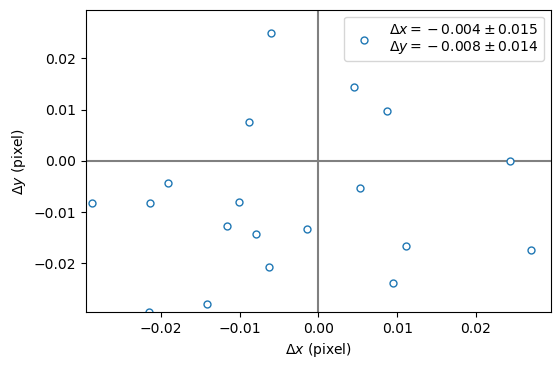

In [225]:
plt.figure()
plt.xlabel("$\Delta x$ (pixel)")
plt.ylabel("$\Delta y$ (pixel)")
plt.xlim(-dmax, dmax)
plt.ylim(-dmax, dmax)
plt.axvline(x=0, color='gray', zorder=-1000)
plt.axhline(y=0, color='gray', zorder=-1000)
plt.errorbar(dx, dy, fmt='o', mfc='white', lw=0.5, markersize=5,
            label="$\Delta x=%.3f\pm%.3f$\n$\Delta y=%.3f\pm%.3f$"%(np.mean(dx), np.std(dx), np.mean(dy), np.std(dy)))
plt.legend(loc='best', bbox_to_anchor=(1,1))

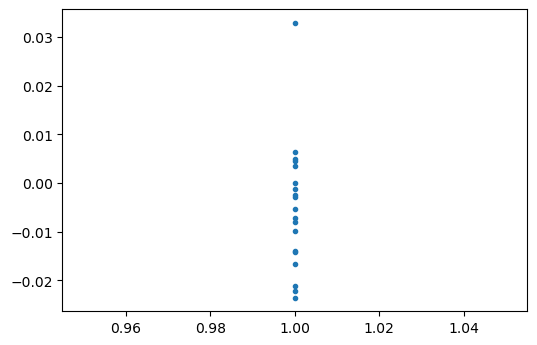

In [229]:
plt.plot(np.r_[norms[:idx_anchor],norms[idx_anchor+1:]], dnorm, '.')

In [217]:
np.mean(popt['xcenters']-xcenters)

DeviceArray(0.02167182, dtype=float64)

In [59]:
mv = gploglike(p_init, gridpsf, idx_anchor, image_obs, image_super, S)

In [60]:
mv.log_prob(image_obs.Z1d)

DeviceArray(-681212.4521585, dtype=float64)

In [22]:
Ns = Nsource
def params_to_dict(params):
    dic = {}
    c = params[:Ns]
    xc = jnp.r_[xcenters[0], params[Ns:Ns+Ns-1]]
    yc = jnp.r_[ycenters[0], params[2*Ns-1:3*Ns-2]]
    lnlenx, lnleny, lna = jnp.array(params[-3:])
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)
    dic['c'] = np.array(c)[1:]
    dic['x'] = np.array(xc)[1:]
    dic['y'] = np.array(yc)[1:]
    dic['lnlenx'] = float(lnlenx)
    dic['lnleny']= float(lnleny)
    dic['lna'] = float(lna)
    return dic

In [23]:
def gpsfloglike(params, Z, sigmaerr, gpsf):

    carr = jnp.r_[1., params[1:Ns]]
    xarr = jnp.r_[xcenters[0], params[Ns:Ns+Ns-1]]
    yarr = jnp.r_[ycenters[0], params[2*Ns-1:3*Ns-2]]
    lnlenx, lnleny, lna = jnp.array(params[-3:])
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)

    fcov = gpkernel(gpsf, lenx, leny, lna)
    
    Amat = jnp.sum(carr[:,None,None] * trans_matrix(spix.X, spix.Y, xarr, yarr, paramseye), axis=0)
    SA = jnp.dot(Smat, Amat)
    cov = jnp.dot(SA, jnp.dot(fcov, SA.T)) + sigmaerr**2 * jnp.eye(pix.Nx*pix.Ny)
    mv = dist.MultivariateNormal(loc=0., covariance_matrix=cov)
    
    return mv.log_prob(Z.ravel())

objective = lambda p: -gpsfloglike(p, Zobs, sigmaerr, gpsf)

In [24]:
def loglikelihood(params, Z1d, sigmaerr):
    #c = params[:Ns]
    c = jnp.r_[1, params[1:Ns]]
    xc = jnp.r_[xcenters[0], params[Ns:Ns+Ns-1]]
    yc = jnp.r_[ycenters[0], params[2*Ns-1:3*Ns-2]]
    lnlenx, lnleny, lna = jnp.array(params[-3:])
    #lnlenx, lnleny, lna = 1., 1., -3.
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)
    
    dx = gpsf.X1d[:,None] - gpsf.X1d[None,:]
    dy = gpsf.Y1d[:,None] - gpsf.Y1d[None,:]
    dx2 = jnp.power(dx / lenx, 2.0)
    dy2 = jnp.power(dy / leny, 2.0)
    kernel = jnp.exp(2*lna) * jnp.exp(-0.5*dx2-0.5*dy2)

    Amat = c[:,None,None] * trans_matrix(spix.X, spix.Y, xc, yc, paramseye)
    #Amat = jnp.sum(Amat, axis=0)
    Amat = jnp.dot(Smat, jnp.sum(Amat, axis=0))

    cov = jnp.dot(Amat, jnp.dot(kernel, Amat.T))
    cov += sigmaerr**2 * jnp.eye(pix.Nx*pix.Ny)
    
    SinvZ = jnp.linalg.solve(cov, Z1d)

    #return -0.5 * len(Z1d) * jnp.linalg.slogdet(cov)[1] - 0.5 * jnp.dot(Z1d.T, SinvZ)
    return -0.5 * jnp.linalg.slogdet(cov)[1] - 0.5 * jnp.dot(Z1d.T, SinvZ) - 0.5 * len(Z1d) * jnp.log(2*jnp.pi)

#objective = lambda p: -loglikelihood(p, Zobs.ravel(), sigmaerr)

In [25]:
width = 2.
shift = 0.
params = np.array([1.]*Ns + list(xcenters[1:]-1.*0.5) + list(ycenters[1:]+1.*0.5) + [0, 0, -5])
params_lower = [0]*Ns + list(xcenters[1:]-width) + list(ycenters[1:]-width) + [-5+3, -5+3, -10.]
params_upper = [10]*Ns + list(xcenters[1:]+width) + list(ycenters[1:]+width) + [2., 2., 0.]
bounds = (params_lower, params_upper)

In [26]:
import jaxopt
method = "TNC"
#method = "Nelder-Mead"
solver = jaxopt.ScipyBoundedMinimize(fun=objective, method=method)#, options={'gtol': 1e-100, 'maxfun': 10000})

In [29]:
%time loglikelihood(params, Zobs.ravel(), sigmaerr)

CPU times: user 37.9 ms, sys: 3.06 ms, total: 41 ms
Wall time: 25.6 ms


DeviceArray(33.00384964, dtype=float64)

In [30]:
%time gpsfloglike(params, Zobs, sigmaerr, gpsf)

CPU times: user 31.8 ms, sys: 2.1 ms, total: 33.9 ms
Wall time: 19.7 ms


DeviceArray(33.00384964, dtype=float64)

In [31]:
def show_res(res):
    print ()
    print (res)
    popt, state = res
    pdict = params_to_dict(popt)
    xmean = pdict['x']
    ymean = pdict['y']
    dx = xmean - xcenters[1:]
    dy = ymean - ycenters[1:]
    print ("# dx = %.3f +/- %.3f"%(np.mean(dx),np.std(dx)))
    print ("# dy = %.3f +/- %.3f"%(np.mean(dy),np.std(dy)))
    return popt, pdict

In [32]:
%%time
res = solver.run(params, bounds=bounds)
popt, pdict = show_res(res)


OptStep(params=DeviceArray([ 1.        ,  0.99705979,  0.99646071,  0.98509137,
              0.97819597,  1.00387094,  1.03265963,  1.01023966,
              1.10913083,  1.46653178,  0.98547642,  1.00109839,
              0.9936165 ,  1.29466149,  0.99836367,  0.98260489,
              1.10586422,  0.97570872,  0.99122444,  1.03139831,
             22.35824598, 17.15103286, 13.72649885, 11.53434934,
              8.20627569, 20.04946912, 11.83657456,  8.45055005,
             23.39092095, 17.97171826,  3.69766735, 11.67780889,
             29.27081488, 14.00718883,  4.2109357 ,  1.25391281,
             21.86569596, 18.4799653 , 27.07070716,  7.78308421,
             16.6609535 , 12.14141112,  4.23881475, 17.30468195,
             15.77182219, 28.14918386, 28.77850948, 29.54643697,
              6.91563486,  2.92220752,  7.36438046, 20.70756984,
              5.89433696, 24.88053601, 10.39029475, 15.42058134,
             19.81800896, 27.9968426 ,  0.25102973,  0.31222459,
         

In [33]:
xmean = pdict['x']#[1:]
ymean = pdict['y']#[1:]
xstd, ystd = 0*xmean, 0*ymean
dmax = np.r_[np.abs(xmean-xcenters[1:]-shift)+np.abs(xstd), np.abs(ymean-ycenters[1:]-shift)+np.abs(ystd)].max()
print (np.mean(xmean-xcenters[1:]), np.mean(ymean-ycenters[1:]))

-0.0032884602034245073 -0.008596941305846194


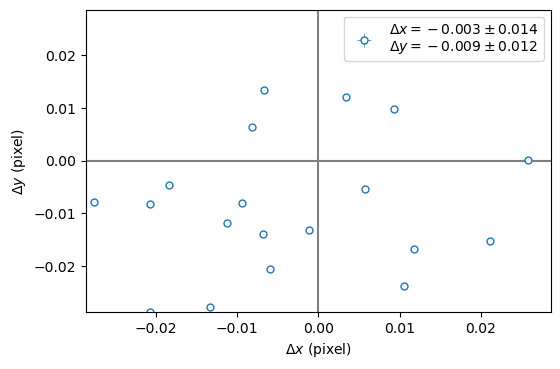

In [34]:
plt.figure()
plt.xlabel("$\Delta x$ (pixel)")
plt.ylabel("$\Delta y$ (pixel)")
plt.xlim(-dmax, dmax)
plt.ylim(-dmax, dmax)
plt.axvline(x=0, color='gray', zorder=-1000)
plt.axhline(y=0, color='gray', zorder=-1000)
dx = xmean-xcenters[1:]-shift
dy = ymean-ycenters[1:]-shift
plt.errorbar(dx, dy, xerr=xstd, yerr=ystd, fmt='o', mfc='white', lw=0.5, markersize=5,
            label="$\Delta x=%.3f\pm%.3f$\n$\Delta y=%.3f\pm%.3f$"%(np.mean(dx), np.std(dx), np.mean(dy), np.std(dy)))
plt.legend(loc='best', bbox_to_anchor=(1,1))

In [115]:
def prediction(params, Z1d, sigmaerr, return_matrices=False):
    c = jnp.r_[1, params[1:Ns]]
    xc = jnp.r_[xcenters[0], params[Ns:Ns+Ns-1]]
    yc = jnp.r_[ycenters[0], params[2*Ns-1:3*Ns-2]]
    lnlenx, lnleny, lna = jnp.array(params[-3:])
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)
    
    dx = gpsf.X1d[:,None] - gpsf.X1d[None,:]
    dy = gpsf.Y1d[:,None] - gpsf.Y1d[None,:]
    dx2 = jnp.power(dx / lenx, 2.0)
    dy2 = jnp.power(dy / leny, 2.0)
    
    Sf = jnp.exp(2*lna) * jnp.exp(-0.5*dx2-0.5*dy2)
    Tmat = c[:,None,None] * trans_matrix(spix.X, spix.Y, xc, yc, paramseye)
    U = jnp.dot(Smat, jnp.sum(Tmat, axis=0))
    Sd = sigmaerr**2 * jnp.eye(pix.Nx*pix.Ny)
    Pd = jnp.eye(pix.Nx*pix.Ny) / sigmaerr**2
    if return_matrices:
        return Sf, Sd, U, Pd
    
    # for ePSF
    Sigma_pred = Sf - Sf@U.T@jnp.linalg.inv(Sd+U@Sf@U.T)@U@Sf
    mu_pred = Sigma_pred@U.T@Pd@Z1d
    
    # for image
    #Sigma_pred = Sd - Sd@U@(Sf - Sf@U.T@jnp.linalg.inv(Pd + U@Sf@U.T)@U@Sf)@U.T@Sd
    #mu_pred = Sigma_pred@Pd@Z1d

    return mu_pred, Sigma_pred, U

In [301]:
mu_pred, Sigma_pred, U = prediction(popt, Zobs.ravel(), sigmaerr)

In [302]:
meanpsf = mu_pred.reshape(gpsf.Nx,gpsf.Ny)
meanpsf /= jnp.sum(meanpsf*gpsf.ds)
Xg, Yg = np.meshgrid(gpsf.xgrid_center, gpsf.ygrid_center)
truepsf = truepsffunc(Xg, Yg, 0, 0, **truepsfkws)
truepsf /= jnp.sum(truepsf*gpsf.ds)

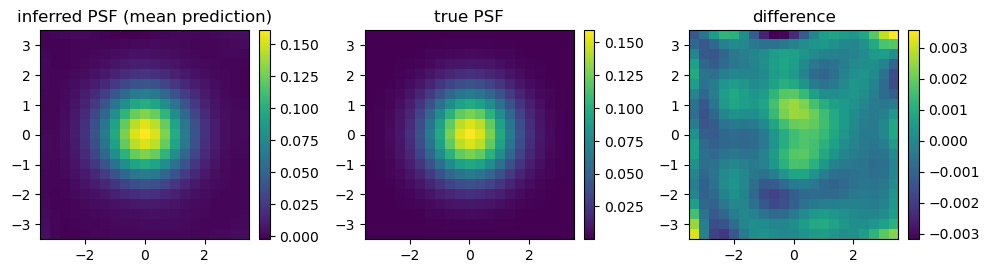

In [303]:
fig, ax = plt.subplots(1,3,figsize=(10,10))
for i,(image,title) in enumerate(zip([meanpsf, truepsf, meanpsf-truepsf], ['inferred PSF (mean prediction)', 'true PSF', 'difference'])):
    im = ax[i].imshow(image, origin='lower', extent=[gpsf.xgrid_edge[0], gpsf.xgrid_edge[-1], gpsf.ygrid_edge[0], gpsf.ygrid_edge[-1]])
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    ax[i].set_title(title)
fig.tight_layout()

/tmp/ipykernel_32043/1404022010.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[1].set_ylim(ylim)


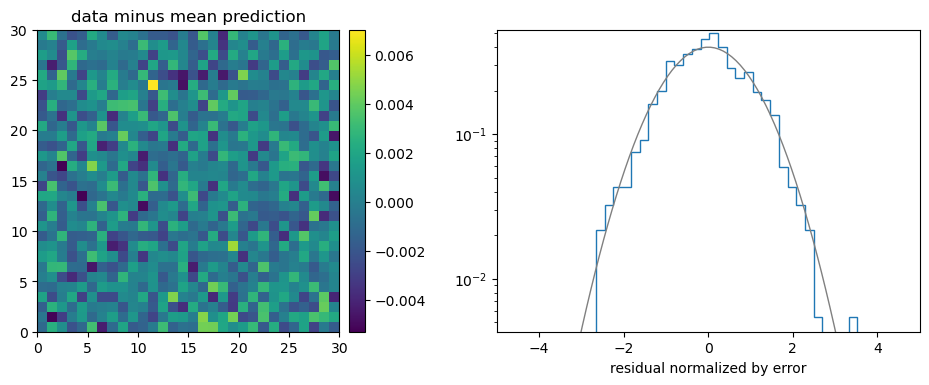

In [304]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
im = ax[0].imshow(Zobs-(U@mu_pred).reshape(pix.Nx,pix.Ny), origin='lower', 
                  extent=[pix.xgrid_edge[0], pix.xgrid_edge[-1], pix.ygrid_edge[0], pix.ygrid_edge[-1]])
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax[0].set_title('data minus mean prediction')
ax[1].hist(np.array(Zobs.ravel()-(U@mu_pred))/sigmaerr, histtype='step', lw=1, bins=30, density=True)
ylim = ax[1].get_ylim()
ax[1].set_yscale("log")
ax[1].set_xlim(-5,5)
ax[1].set_ylim(ylim)
x0 = np.linspace(-5, 5, 100)
ax[1].plot(x0, np.exp(-0.5*x0**2)/np.sqrt(2*np.pi), color='gray', lw=1)
ax[1].set_xlabel("residual normalized by error");

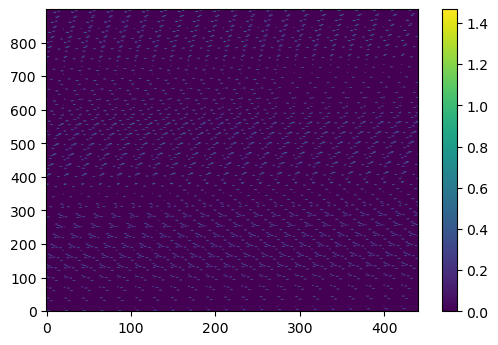

In [305]:
# U is sparse
plt.imshow(U, aspect='auto', origin='lower')
plt.colorbar()

In [306]:
from tinygp import kernels, GaussianProcess
width = 2.
shift = 0.
def gpsfmodel(Z, sigmaerr, gpsf, xcenters, ycenters):
    lnlenx = numpyro.sample("lnlenx", dist.Uniform(low=-2, high=2)) # fail for lnlenx > 0? -> only fcov
    lnleny = numpyro.sample("lnleny", dist.Uniform(low=-2, high=2))
    lna = numpyro.sample("lna", dist.Uniform(low=-10, high=0))
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)
    fcov = gpkernel(gpsf, lenx, leny, lna)
    
    #mv = dist.MultivariateNormal(loc=0., covariance_matrix=fcov)
    #numpyro.sample("psfvals1d", mv)
    
    ones = jnp.ones_like(xcenters) 
    c = numpyro.sample("c", dist.TruncatedNormal(loc=ones[1:], scale=ones[1:], low=ones[1:]*0.))
    x = numpyro.sample("x", dist.Uniform(low=xcenters[1:]-width, high=xcenters[1:]+width))
    y = numpyro.sample("y", dist.Uniform(low=ycenters[1:]-width, high=ycenters[1:]+width))
    
    carr = jnp.r_[1., c]
    xarr = jnp.r_[xcenters[0]+shift, x]
    yarr = jnp.r_[ycenters[0]+shift, y] 
    Amat = jnp.sum(carr[:,None,None] * trans_matrix(spix.X, spix.Y, xarr, yarr, paramseye), axis=0)
    SA = jnp.dot(Smat, Amat)
    
    cov = jnp.dot(SA, jnp.dot(fcov, SA.T)) + sigmaerr**2 * jnp.eye(pix.Nx*pix.Ny)
    mv = dist.MultivariateNormal(loc=0., covariance_matrix=cov)

    numpyro.factor("loglike", mv.log_prob(Z.ravel()))
    #numpyro.sample("im1d", mv)
    #numpyro.sample("obs", mv, obs=Z.ravel())

In [307]:
from numpyro.infer import init_to_value
init_strategy = init_to_value(values=pdict)

In [48]:
kernel = numpyro.infer.NUTS(gpsfmodel, target_accept_prob=0.90, init_strategy=init_strategy)

In [49]:
nw, ns = 500, 500
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
rng_key = random.PRNGKey(0)

In [50]:
mcmc.run(rng_key, Zobs, sigmaerr, gpsf, xcenters, ycenters)

  0%|                                                                                                              | 0/1000 [00:00<?, ?it/s]/home/masuda/anaconda3/lib/python3.9/site-packages/jax/_src/tree_util.py:200: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|████████████████████████████████████████████████| 1000/1000 [12:14<00:00,  1.36it/s, 15 steps of size 1.64e-01. acc. prob=0.94]


In [51]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      c[0]      1.00      0.01      1.00      0.98      1.02     75.11      1.04
      c[1]      1.00      0.01      1.00      0.98      1.02     73.99      1.04
      c[2]      0.99      0.01      0.99      0.97      1.00    100.29      1.03
      c[3]      0.98      0.01      0.98      0.96      1.00     93.26      1.04
      c[4]      1.01      0.01      1.01      0.99      1.02     91.54      1.04
      c[5]      1.03      0.02      1.03      1.00      1.06     51.05      1.00
      c[6]      1.01      0.01      1.01      1.00      1.03     68.08      1.05
      c[7]      1.11      0.01      1.11      1.10      1.13     81.75      1.04
      c[8]      1.47      0.02      1.47      1.44      1.49     78.79      1.02
      c[9]      0.99      0.01      0.99      0.97      1.00     77.34      1.04
     c[10]      1.00      0.01      1.00      0.98      1.02    104.15      1.03
     c[11]      1.00      0

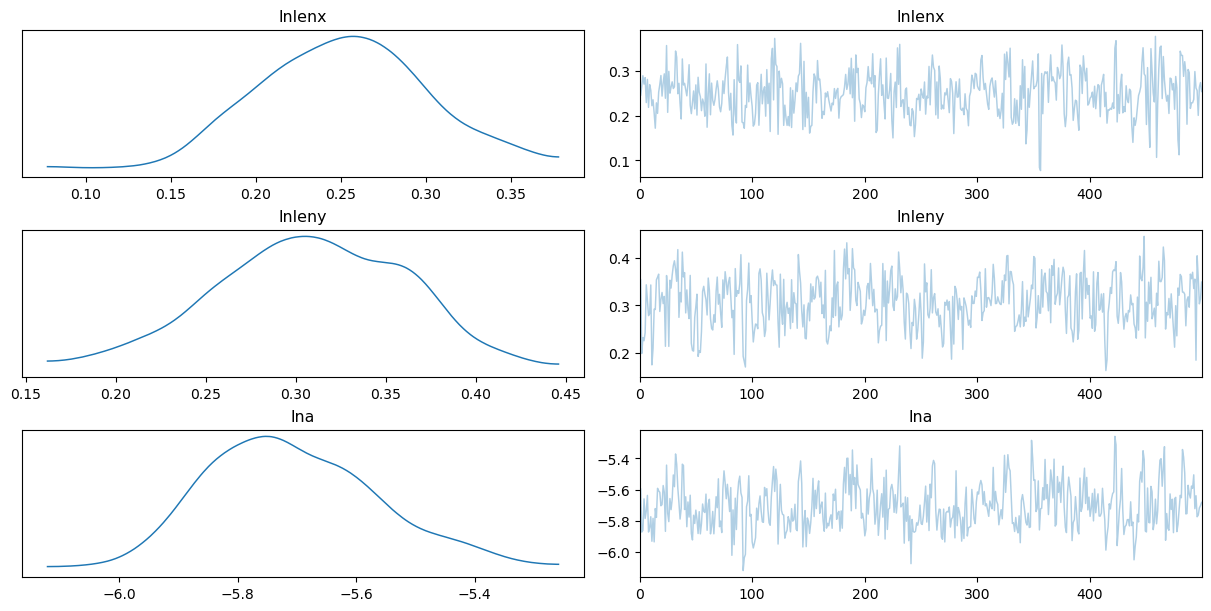

In [52]:
from numpyro.infer import Predictive
from arviz import plot_trace
fig = plot_trace(mcmc, var_names=['lnlenx', 'lnleny', 'lna'])

In [53]:
smp = mcmc.get_samples()

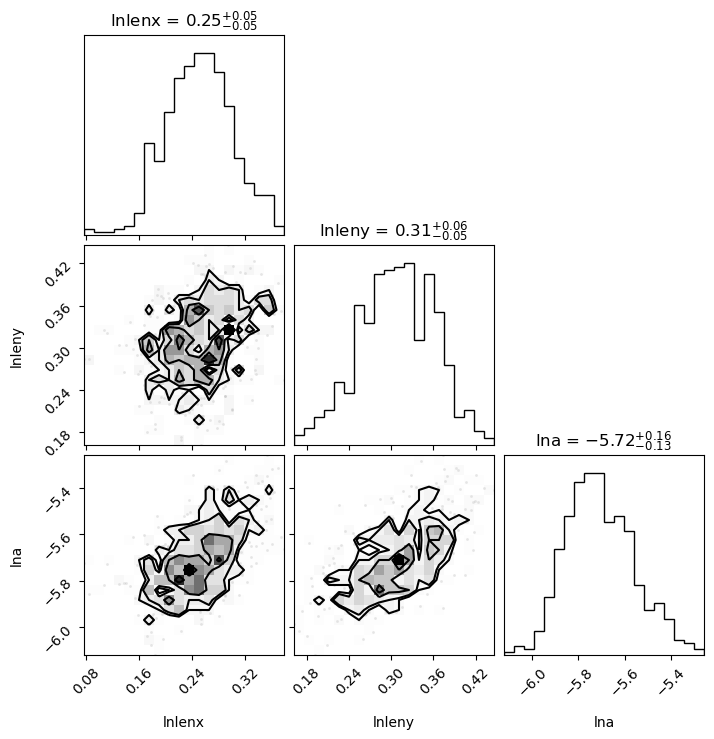

In [54]:
import pandas as pd
pnames = ["lnlenx", "lnleny", "lna"]
hyper = pd.DataFrame(data=dict(zip(pnames, [smp[k] for k in pnames])))
fig = corner.corner(hyper, labels=pnames, show_titles="%.2f")

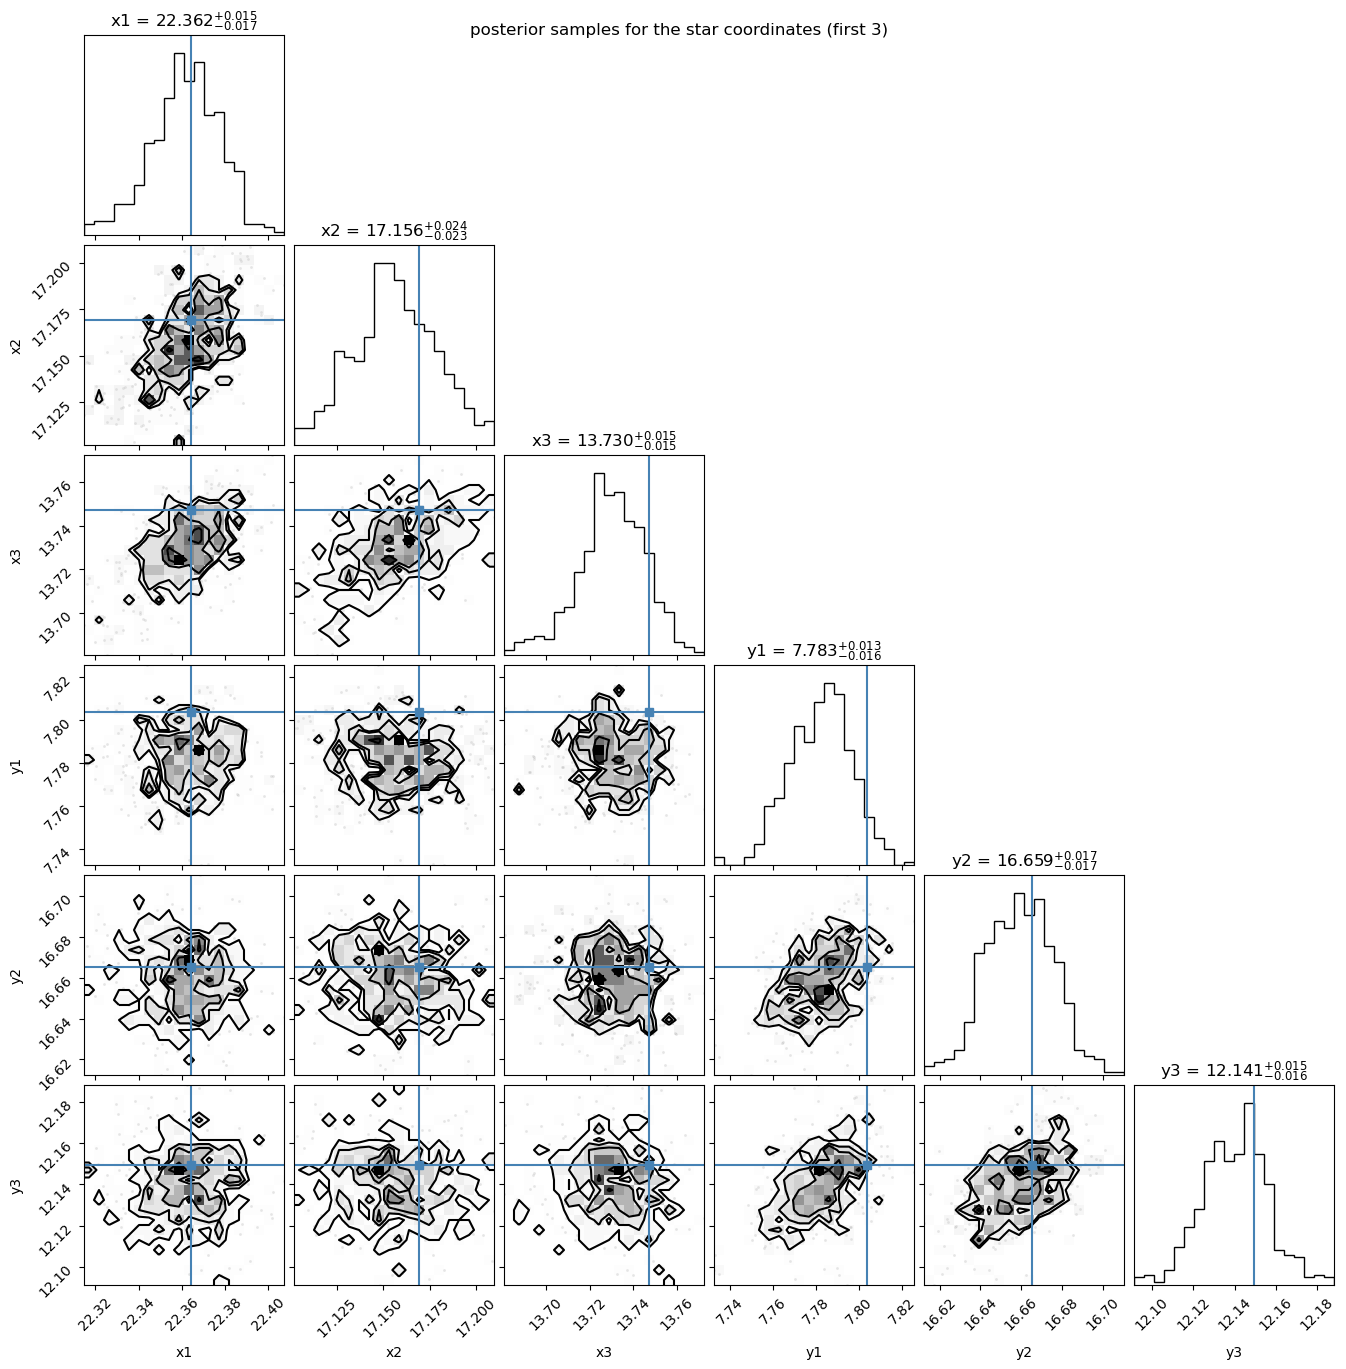

In [55]:
nplot = 3
fig = corner.corner(np.c_[np.array(smp['x'])[:,:nplot], np.array(smp['y'])[:,:nplot]], 
                    show_titles=True, title_fmt=".3f",
                    truths=np.r_[xcenters[1:][:nplot]+shift, ycenters[1:][:nplot]+shift],
                   labels=["x%d"%i for i in range(1,nplot+1)]+["y%d"%i for i in range(1,nplot+1)])
fig.suptitle("posterior samples for the star coordinates (first %d)"%nplot);

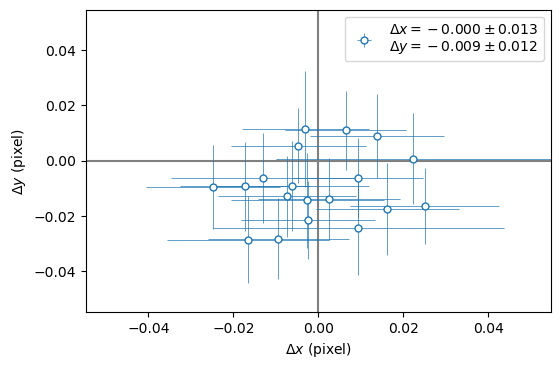

In [225]:
xmean, xstd = np.mean(smp['x'], axis=0), np.std(smp['x'], axis=0)
ymean, ystd = np.mean(smp['y'], axis=0), np.std(smp['y'], axis=0)
dmax = np.r_[np.abs(xmean-xcenters[1:]-shift)+np.abs(xstd), np.abs(ymean-ycenters[1:]-shift)+np.abs(ystd)].max()
plt.figure()
plt.xlabel("$\Delta x$ (pixel)")
plt.ylabel("$\Delta y$ (pixel)")
plt.xlim(-dmax, dmax)
plt.ylim(-dmax, dmax)
plt.axvline(x=0, color='gray', zorder=-1000)
plt.axhline(y=0, color='gray', zorder=-1000)
dx = xmean-xcenters[1:]-shift
dy = ymean-ycenters[1:]-shift
plt.errorbar(dx, dy, xerr=xstd, yerr=ystd, fmt='o', mfc='white', lw=0.5, markersize=5,
            label="$\Delta x=%.3f\pm%.3f$\n$\Delta y=%.3f\pm%.3f$"%(np.mean(dx), np.std(dx), np.mean(dy), np.std(dy)))
plt.legend(loc='best', bbox_to_anchor=(1,1));

In [311]:
#truepsf = truepsffunc(gpsf.X1d, gpsf.Y1d, 0, 0, **truepsfkws) 
#truepsf /= jnp.sum(truepsf*gpsf.ds)
#f_mean = 1./(gpsf.Nparams*gpsf.ds)
#parr = jnp.ones(gpsf.Nparams) * f_mean
flux_sums = jnp.sum(trans_matrix(spix.X, spix.Y, xcenters, ycenters, paramseye)@truepsf.ravel(), axis=1)*spix.ds

In [312]:
cmean = np.mean(smp['c'], axis=0)
cstd = np.std(smp['c'], axis=0)
ctrue = 1./flux_sums[1:]

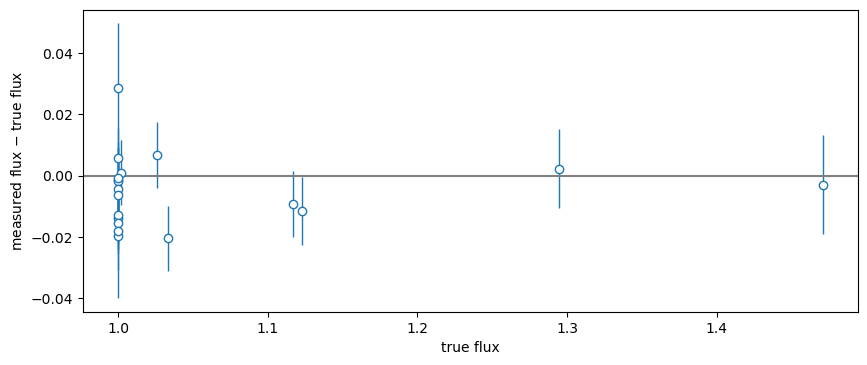

In [313]:
#plt.xscale("log")
#plt.yscale("log")
plt.figure(figsize=(10,4))
plt.xlabel("true flux")
plt.ylabel("measured flux $-$ true flux")
plt.axhline(y=0., color='gray')
plt.errorbar(ctrue, cmean-ctrue, mfc='white', fmt='o', yerr=cstd, lw=1.);